## Further work with confocal image datasets

Yesterday you worked with some statistics derived from an Imaris file. Today,
you will learn how to work directly with the file to extract additional
information. 

As a brief reminder, this dataset is a confocal Z-stack of several inner hair
cells from a gerbil cochlea. These cells have been labeled with antibodies for
pre-synaptic ribbons (CtBP2), post-synaptic receptors (GluR2) and cytoskeleton
(Myosin VIIa). This dataset was analyzed using Imaris to identify CtBP2
"puncta" (i.e., the "spots" from yesterday's class) and the extent of the GluR2
label (the "surface"). 

A functional inner hair cell synapse requires both a pre-synaptic ribbon and a
post-synaptic glutamate receptor. The next step in our analysis is to determine
whether each CtBP2 puncta is near a GluR2 label. There are several ways we can do this, including:

* For each CtBP2 puncta, extract a fixed volume (e.g., 1 um x 1um x 1um)
  from the 3D image and quantify the amount of GluR2 label.

* Calculate the distance from each CtBP2 puncta to the nearest point on the
  GluR2 surface.

Imaris is an open-source file format based on HDF5. A number of languages have
packages for reading this file format. For Python, there are two main packages,
`h5py` and `pytables`. We will use `pytables` for this exercise.


In [1]:
import pylab as pl
import os.path
import tables as tb
import numpy as np
import imaris

%matplotlib inline

#pathname = '/auto/data/daq/gerbil/confocal/170705.1 middle R'
#filename = '170705.0 middle R 11.3 kHz MyosinVIIA CtBP2 GluR2 IHC ASR_Out.ims'
pathname = '/auto/data/daq/gerbil/confocal/170705.0 left L'
filename = '170705.0 left L 0.7 kHz MyosinVIIA CtBP2 GluR2 IHC ASR_Out.ims'

filename = os.path.join(pathname, filename)
fh = tb.open_file(filename)

First, we need to figure out how to find the image data. We can start by taking a look at the file. Since HDF5 is a hierarchial data format, data inside the file is stored in a tree-like structure. We can view this structure using `print`.

In [2]:
print(fh)

/auto/data/daq/gerbil/confocal/170705.0 left L/170705.0 left L 0.7 kHz MyosinVIIA CtBP2 GluR2 IHC ASR_Out.ims (File) ''
Last modif.: 'Fri Dec  1 15:40:49 2017'
Object Tree: 
/ (RootGroup) ''
/DataSet (Group) ''
/DataSetInfo (Group) ''
/DataSetTimes (Group) ''
/DataSetTimes/Time (Table(1,)) ''
/DataSetTimes/TimeBegin (Table(1,)) ''
/Scene (Group) ''
/Scene/Data (VLArray(1,)) ''
/Scene8 (Group) ''
/Scene8/Data (VLArray(1,)) ''
/Thumbnail (Group) ''
/Thumbnail/Data (Array(256, 1024)) ''
/Scene8/Content (Group) ''
/Scene8/Content/Points0 (Group) ''
/Scene8/Content/Points0/Category (Table(2,)) ''
/Scene8/Content/Points0/Factor (Table(6,)) ''
/Scene8/Content/Points0/FactorList (Table(6,)) ''
/Scene8/Content/Points0/LabelGroupNames (Table(0,)) ''
/Scene8/Content/Points0/LabelSetLabelIDs (Table(0,)) ''
/Scene8/Content/Points0/LabelSetObjectIDs (Table(0,)) ''
/Scene8/Content/Points0/LabelSets (Table(0,)) ''
/Scene8/Content/Points0/LabelValues (Table(0,)) ''
/Scene8/Content/Points0/MainTrackSegm

This is a lot of information! However, in scanning the list there are several
things that jump out as important clues. First, remember that the tissue has
three labels (CtBP2, GluR2 and MyosinVIIa). In confocal imaging, each label is
acquired using a separate channel. At the bottom of the list we see several
rows that mention `Channel 0`, `Channel 1` and `Channel 2`. This is most likely
the data we need.

However, the channels appear several times (under `ResolutionLevel 0`,
`ResolutionLevel 1`, and `ResolutionLevel 2`). Which one do we want? Our
intuition as a programmer tells us that Imaris likely generates the dataset at
multiple resolutions and uses the appropriate resolution based on your zoom
level. For quantitative analysis, we probably want the highest resolution
level. 

Take another look at the list. You'll notice that at the end of each line
there's an indicator in parenthesis (`Group`, `Array`, `CArray`). These are the
different types of nodes (i.e., entries) in the HDF5 file. The simplest way to
think of a HDF5 file is that it's a self-contained filesystem. A `group` node
is equivalent to a folder. A `leaf` node (e.g., `Array`, `CArray`, `Table`) is
equivalent to a file. Group nodes are used to organize the data in the HDF5
file.

Now, let's look at the `Channel 0/Data` line for each resolution level. There's
some information about the size of the array. This tells us that
`ResolutionLevel 0` contains the highest resolution data and `ResolutionLevel
2` contains the lowest resolution data. Otherwise, they should be identical.

First, let's take a look at a single node so we can understand how to work with
the data.

In [3]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 2/Data')
data = node.read()
print(data.shape)

(160, 512, 1920)


This is a 3D `numpy` array. Based on how the data was acquired, the shortest dimension is the Z-axis
and the longest dimension is the X-axis, this suggests that the ordering of the
dimensions in the array is Z, Y, X. 

There are ways to visualize 3D data in Python. However, these approaches are
not readily available out of the box. Let's focus on simple 2D plotting
instead. A common way of presenting confocal image stacks is to take the
maximum projection along an an axis (i.e., dimension). Let's take the maximum
projection along the first axis (i.e., Z-axis) and plot it using `imshow`.

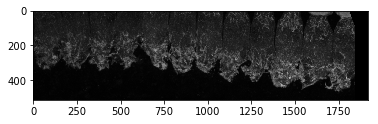

In [4]:
projection = data.max(axis=0)
pl.imshow(projection, cmap='gray')

Looks good. Now let's load the other channels and plot them.

In [5]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 1/Data')
data_GluR2 = node.read()
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data')
data_CtBP2 = node.read()
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 2/Data')
data_MyosinVIIa = node.read()

In [6]:
extents = imaris.get_image_extents(fh)

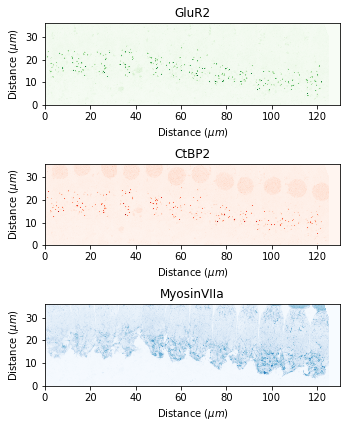

In [7]:
f, axes = pl.subplots(3, 1, figsize=(6, 6))
extent = 0, extents['x_span'], 0, extents['y_span']

projection_GluR2 = data_GluR2.max(axis=0)
projection_CtBP2 = data_CtBP2.max(axis=0)
projection_MyosinVIIa = data_MyosinVIIa.max(axis=0)

axes[0].imshow(projection_GluR2, extent=extent, cmap='Greens')
axes[1].imshow(projection_CtBP2, extent=extent, cmap='Reds')
axes[2].imshow(projection_MyosinVIIa, extent=extent, cmap='Blues')

axes[0].set_title('GluR2')
axes[1].set_title('CtBP2')
axes[2].set_title('MyosinVIIa')

for ax in axes:
    ax.set_xlabel('Distance ($\mu m$)')
    ax.set_ylabel('Distance ($\mu m$)')

pl.tight_layout()

In [8]:
data_CtBP2 = data_CtBP2.astype('f')/np.max(data_CtBP2)
data_GluR2 = data_GluR2.astype('f')/np.max(data_GluR2)
data_MyosinVIIa = data_MyosinVIIa.astype('f')/np.max(data_MyosinVIIa)

(512, 1920, 3)


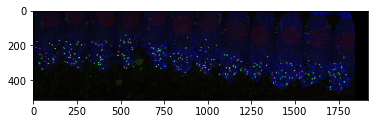

In [9]:
projection_CtBP2 = data_CtBP2.max(axis=0)
projection_GluR2 = data_GluR2.max(axis=0)
projection_MyosinVIIa = data_MyosinVIIa.max(axis=0)

normed_projection = np.concatenate((
    projection_CtBP2[..., np.newaxis],
    projection_GluR2[..., np.newaxis],
    projection_MyosinVIIa[..., np.newaxis],
), axis=-1)

print(normed_projection.shape)
pl.imshow(normed_projection)

In [10]:
stats_CtBP2 = imaris.load_node_stats(fh, 'CtBP2', 'point')

7.93421 0.07058850406504064
59.7462 0.07058845401174169
0.0 0.15945185185185184


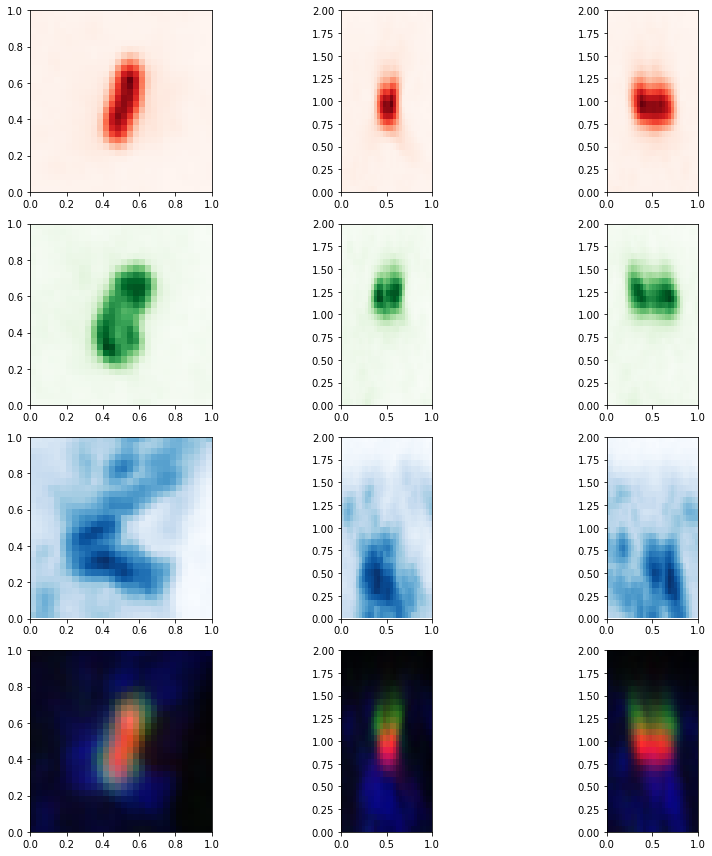

In [11]:
i = stats_CtBP2['Volume'].argmax()
point = stats_CtBP2.loc[i]
xlb, ylb, zlb = point[['index_X', 'index_Y', 'index_Z']].astype('i')-15
xub, yub, zub = point[['index_X', 'index_Y', 'index_Z']].astype('i')+15

subset_GluR2 = data_GluR2[zlb:zub, ylb:yub, xlb:xub]  
subset_CtBP2 = data_CtBP2[zlb:zub, ylb:yub, xlb:xub]  
subset_MyosinVIIa = data_MyosinVIIa[zlb:zub, ylb:yub, xlb:xub]  

f, axes = pl.subplots(4, 3, figsize=(12, 12))
for i in range(3):
    if i != 0:
        extent = 0, 1, 0, 2
    else:
        extent = 0, 1, 0, 1
    subset_projection_CtBP2 = subset_CtBP2.max(axis=i)
    subset_projection_GluR2 = subset_GluR2.max(axis=i)
    subset_projection_MyosinVIIa = subset_MyosinVIIa.max(axis=i)
    axes[0, i].imshow(subset_projection_CtBP2, extent=extent, cmap='Reds')
    axes[1, i].imshow(subset_projection_GluR2, extent=extent, cmap='Greens')
    axes[2, i].imshow(subset_projection_MyosinVIIa, extent=extent, cmap='Blues')
    
    subset_projection = np.concatenate((
        subset_projection_CtBP2[..., np.newaxis],
        subset_projection_GluR2[..., np.newaxis],
        subset_projection_MyosinVIIa[..., np.newaxis],
    ), axis=-1)
    axes[3, i].imshow(subset_projection, extent=extent)
    
pl.tight_layout()

In [12]:
signal = []
for p, point_stats in stats_CtBP2.iterrows():
    xlb, ylb, zlb = np.clip(point_stats[['index_X', 'index_Y', 'index_Z']].astype('i')-15, 0, np.inf).astype('i')
    xub, yub, zub = point_stats[['index_X', 'index_Y', 'index_Z']].astype('i')+15
    subset_GluR2 = data_GluR2[zlb:zub, ylb:yub, xlb:xub]  
    signal.append(np.mean(subset_GluR2))
    
stats_CtBP2['GluR2'] = signal

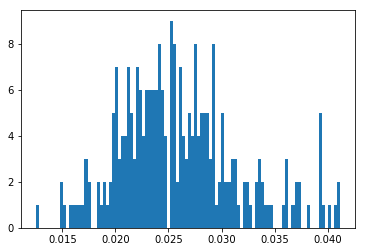

In [13]:
pl.hist(stats_CtBP2['GluR2'], bins=100);

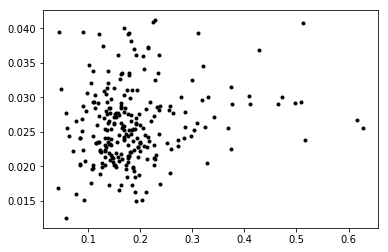

In [14]:
pl.plot(stats_CtBP2['Volume'], stats_CtBP2['GluR2'], 'k.')

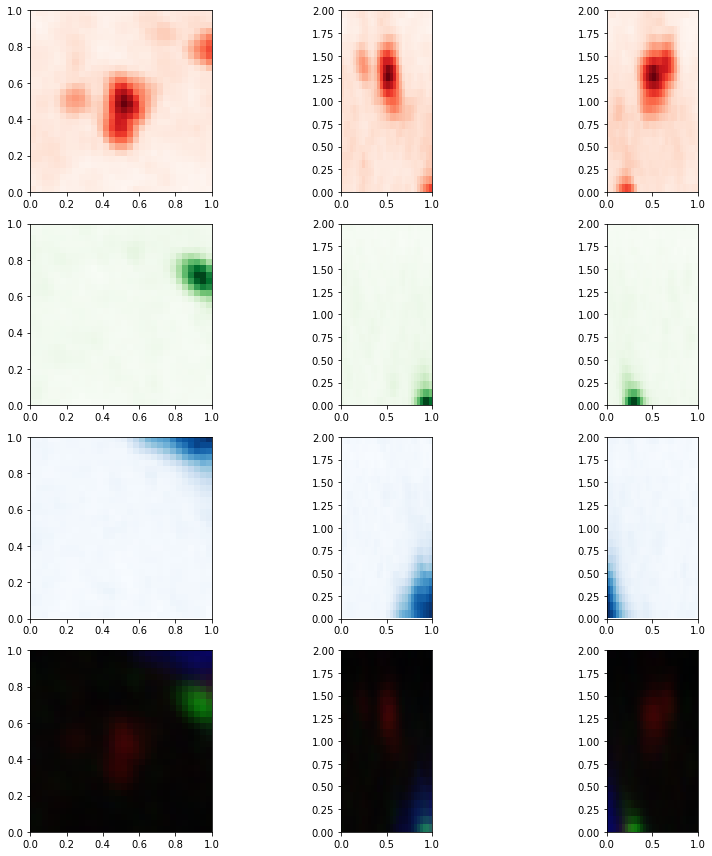

In [15]:
i = stats_CtBP2['GluR2'].argmin()
point = stats_CtBP2.loc[i]
xlb, ylb, zlb = np.clip(point[['index_X', 'index_Y', 'index_Z']].astype('i')-15, 0, np.inf).astype('i')
xub, yub, zub = point[['index_X', 'index_Y', 'index_Z']].astype('i')+15

subset_GluR2 = data_GluR2[zlb:zub, ylb:yub, xlb:xub]  
subset_CtBP2 = data_CtBP2[zlb:zub, ylb:yub, xlb:xub]  
subset_MyosinVIIa = data_MyosinVIIa[zlb:zub, ylb:yub, xlb:xub]  

f, axes = pl.subplots(4, 3, figsize=(12, 12))
for i in range(3):
    if i != 0:
        extent = 0, 1, 0, 2
    else:
        extent = 0, 1, 0, 1
    subset_projection_CtBP2 = subset_CtBP2.max(axis=i)
    subset_projection_GluR2 = subset_GluR2.max(axis=i)
    subset_projection_MyosinVIIa = subset_MyosinVIIa.max(axis=i)
    axes[0, i].imshow(subset_projection_CtBP2, extent=extent, cmap='Reds')
    axes[1, i].imshow(subset_projection_GluR2, extent=extent, cmap='Greens')
    axes[2, i].imshow(subset_projection_MyosinVIIa, extent=extent, cmap='Blues')
    
    subset_projection = np.concatenate((
        subset_projection_CtBP2[..., np.newaxis],
        subset_projection_GluR2[..., np.newaxis],
        subset_projection_MyosinVIIa[..., np.newaxis],
    ), axis=-1)
    axes[3, i].imshow(subset_projection, extent=extent)
    
pl.tight_layout()